In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tda.sim.sim_engine import Simulation
from tda.sim.sim_objects.lti_object import LTIObject
from tda.sim.sensors import clutter_model
from tda.sim.sensors.radar import Radar

from tda.tracker.filters.extended_kalman import ExtendedKalman

from tda.common.measurement import Measurement
from tda.tracker.track import Track
from tda.tracker.tracker import Tracker
from tda.tracker.tracker_param import TrackerParam
from tda.sim.ground_truth import GroundTruth

In [2]:
sim = Simulation()

R = np.array([[np.pi / 180, 0, 0],
              [0, np.pi / 180, 0],
              [0, 0, 10]])

R = np.eye(3) * 1e-6

platform = LTIObject(1, np.array([0, 0, 0]), sim, np.zeros((3, 3)))
radar = Radar(1, platform, 5.0, R)
platform.add_payload(radar)

target_Q = np.zeros((6, 6))
target_Q[0, 0] = 0.25
target_Q[1, 1] = 0.33
target_Q[2, 2] = 1e-6
target_Q[3, 3] = 1e-6
target_Q[4, 4] = 1e-6
target_Q[5, 5] = 1e-6


target = LTIObject(2, np.array([10, 12, 0, 1, 2, 0]), sim, target_Q)

sim._sim_objects.extend([platform, target])

In [3]:
sim_records = sim.run()

In [4]:
sim_records

{'radar1': {'t': array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50., 55., 60.]),
  'sensor_id': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
  'target_id': array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]),
  'target_az': array([-1.2988689 , -1.0480961 , -0.72515268, -0.24432242,  0.09988898,
          0.32083842,  0.5141229 ,  0.58995163,  0.6667243 ,  0.74200171,
          0.79794676,  0.82740169,  0.8693918 ]),
  'target_el': array([1.5712257 , 1.56805939, 1.57167566, 1.57337845, 1.57315092,
         1.57221872, 1.57272948, 1.57272296, 1.57192502, 1.57163207,
         1.57299935, 1.57491842, 1.57211206]),
  'target_rng': array([ 39.05837873,  31.62945359,  26.8920839 ,  27.30349939,
          32.59134376,  38.81618449,  48.39319856,  58.28707549,
          67.13361368,  80.13737787,  90.81113678, 100.41229901,
         110.21195   ]),
  'sensor_x': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  'sensor_y': array([50., 50., 50., 50.

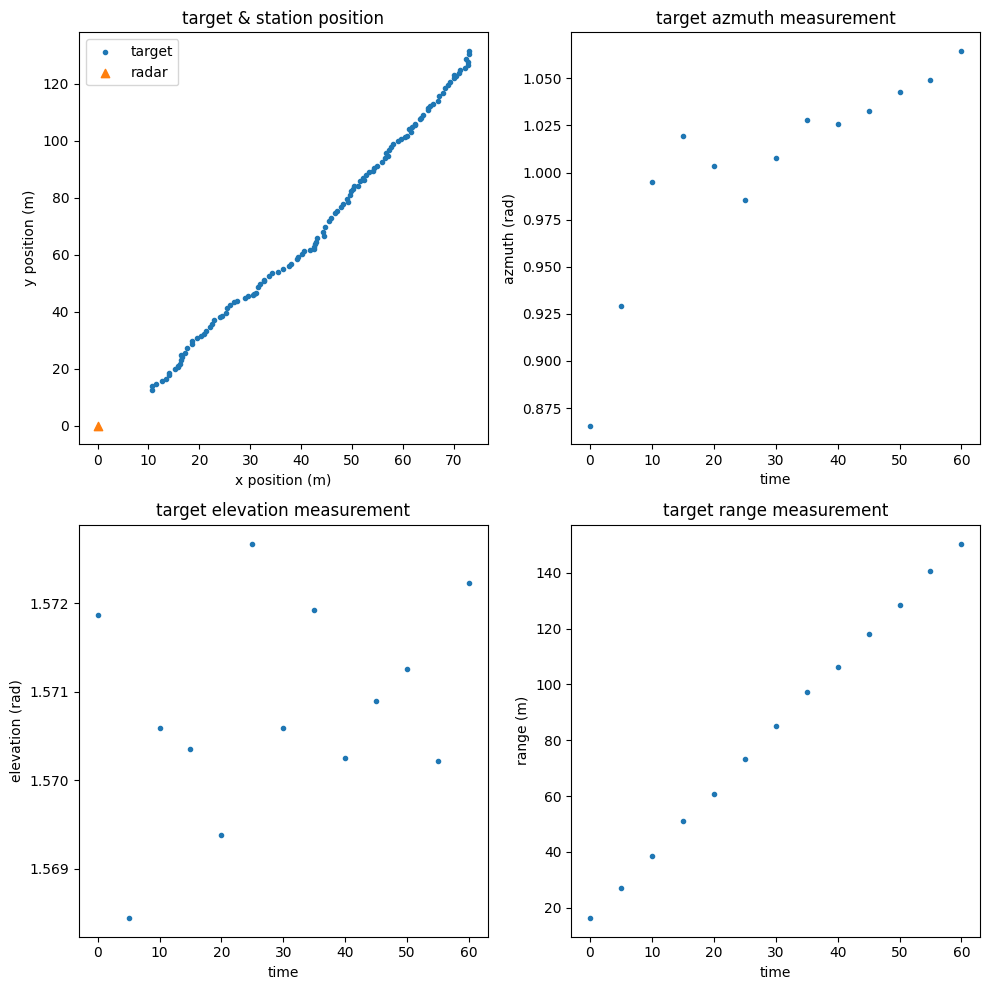

In [4]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches((10, 10))

axs[0, 0].scatter(sim_records["lti_object2"]["x"], sim_records["lti_object2"]["y"], marker=".", label="target")
axs[0, 0].scatter(sim_records["lti_object1"]["x"][0], sim_records["lti_object1"]["y"][0], marker="^", label="radar")
axs[0, 0].set_title("target & station position")
axs[0, 0].set_xlabel("x position (m)")
axs[0, 0].set_ylabel("y position (m)")
axs[0, 0].legend()

axs[0, 1].scatter(sim_records["radar1"]["t"], sim_records["radar1"]["target_az"], marker=".")
axs[0, 1].set_title("target azmuth measurement")
axs[0, 1].set_xlabel("time")
axs[0, 1].set_ylabel("azmuth (rad)")

axs[1, 0].scatter(sim_records["radar1"]["t"], sim_records["radar1"]["target_el"], marker=".")
axs[1, 0].set_title("target elevation measurement")
axs[1, 0].set_xlabel("time")
axs[1, 0].set_ylabel("elevation (rad)")

axs[1, 1].scatter(sim_records["radar1"]["t"], sim_records["radar1"]["target_rng"], marker=".")
axs[1, 1].set_title("target range measurement")
axs[1, 1].set_xlabel("time")
axs[1, 1].set_ylabel("range (m)")

fig.tight_layout()

In [15]:
def get_F(dt: float):
    F = np.eye(6, dtype=np.float64)
    F[0, 3] = F[1, 4] = F[2, 5] = dt
    #F[3, 6] = F[4, 7] = F[5, 8] = dt
    #F[0, 6] = F[1, 7] = F[2, 8] = (dt ** 2) / 2

    return F


def f(dt, x):
    return get_F(dt) @ x


def h(x):
    rho = np.sqrt(x[0]**2 + x[1]**2 + x[2]**2)
    the = np.arctan2(x[1], x[0])
    psi = np.arccos(x[2] / rho)
    
    return np.array([the, psi, rho])

def hinv(y):
    the = y[0]
    psi = y[1]
    rho = y[2]
    x = rho * np.sin(psi) * np.cos(the)
    y = rho * np.sin(psi) * np.sin(the)
    z = rho * np.cos(psi)

    return np.array([x, y, z, 0, 0, 0])


def get_H(X):
    x = X[0]
    y = X[1]
    z = X[2]
    
    return np.array([[-y/(x**2 + y**2), x/(x**2 + y**2), 0, 0, 0, 0],
                     [(x*z)/((1 - z**2/(x**2 + y**2 + z**2))**(1/2)*(x**2 + y**2 + z**2)**(3/2)), (y*z)/((1 - z**2/(x**2 + y**2 + z**2))**(1/2)*(x**2 + y**2 + z**2)**(3/2)), -(1/(x**2 + y**2 + z**2)**(1/2) - z**2/(x**2 + y**2 + z**2)**(3/2))/(1 - z**2/(x**2 + y**2 + z**2))**(1/2), 0, 0, 0],
                     [x/(x**2 + y**2 + z**2)**(1/2), y/(x**2 + y**2 + z**2)**(1/2), z/(x**2 + y**2 + z**2)**(1/2), 0, 0, 0]
                    ])


def Q(dt: float):
    Q = np.zeros((6, 6))
    Q[0, 0] = 0.25
    Q[1, 1] = 0.33
    Q[2, 2] = 1e-6
    Q[3, 3] = 1e-6
    Q[4, 4] = 1e-6
    Q[5, 5] = 1e-6

    return dt * Q * (1 / sim._time_delta)


In [6]:

x_hat_0 = hinv([sim_records["radar1"]["target_az"][0],
                sim_records["radar1"]["target_el"][0],
                sim_records["radar1"]["target_rng"][0]])

print(x_hat_0)

P_hat_0 = 1e9 * np.eye(6)



kf = ExtendedKalman(x_hat_0, P_hat_0, f, get_F, h, get_H, Q, R)

for frame in sim.meas_queue:
    for m in frame:
        kf.update(m)

kf_record = kf.record()

[10.58813679 12.44245079 -0.01744956  0.          0.          0.        ]


In [20]:
kf._filter_history

[(0.0,
  array([ 17.3835068 , -28.96992711,  -0.48008204,   0.        ,
           0.        ,   0.        ]),
  array([[ 1.72957291e+01,  4.37662529e+00,  7.25577035e-02,
           8.64786454e+00,  2.18831264e+00,  3.62788517e-02],
         [ 4.37662550e+00,  1.26282131e+01, -1.20918719e-01,
           2.18831275e+00,  6.31410657e+00, -6.04593594e-02],
         [ 7.25576996e-02, -1.20918719e-01,  1.99239574e+01,
           3.62788498e-02, -6.04593594e-02,  9.96197869e+00],
         [ 8.64786422e+00,  2.18831261e+00,  3.62788523e-02,
           5.00000004e+08,  1.09415631e+00,  1.81394261e-02],
         [ 2.18831265e+00,  6.31410646e+00, -6.04593607e-02,
           1.09415633e+00,  5.00000003e+08, -3.02296804e-02],
         [ 3.62788498e-02, -6.04593594e-02,  9.96197867e+00,
           1.81394249e-02, -3.02296797e-02,  5.00000005e+08]])),
 (5.0,
  array([ 15.51651638, -32.43501605,  -4.93378641,  -0.37339808,
          -0.69301779,  -0.89074087]),
  array([[ 1.72957291e+01,  4.3766248

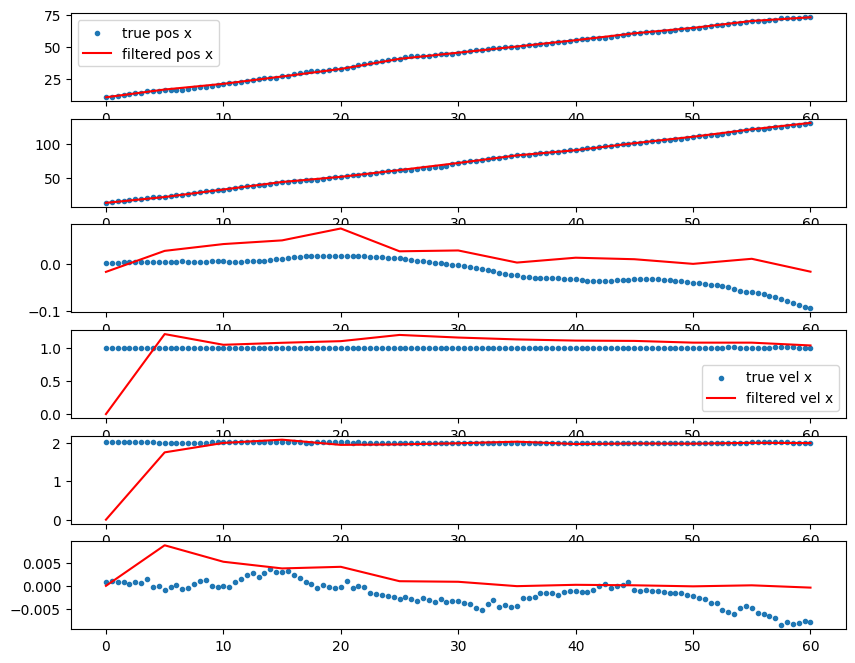

In [7]:
fig, axs = plt.subplots(6)
fig.set_size_inches((10, 8))
axs[0].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["x"], marker=".", label="true pos x")
#axs[0].scatter(sim_records["oracle1"]["t"], sim_records["oracle1"]["target_x"], marker="x", label="measured pos x")
axs[0].plot(kf_record["t"], sim_records["lti_object1"]["x"][0] + kf_record["x_hat"][:, 0], color="red", label="filtered pos x")
axs[0].legend()

axs[1].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["y"], marker=".", label="true pos y")
#axs[1].scatter(sim_records["oracle1"]["t"], sim_records["oracle1"]["target_y"], marker="x", label="measured pos y")
axs[1].plot(kf_record["t"], sim_records["lti_object1"]["y"][0] + kf_record["x_hat"][:, 1], color="red", label="filtered pos y")

axs[2].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["z"], marker=".", label="true pos z")
#axs[2].scatter(sim_records["oracle1"]["t"], sim_records["oracle1"]["target_z"], marker="x", label="measured pos z")
axs[2].plot(kf_record["t"], sim_records["lti_object1"]["z"][0] + kf_record["x_hat"][:, 2], color="red", label="filtered pos z")

axs[3].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["xdot"], marker=".", label="true vel x")
axs[3].plot(kf_record["t"], kf_record["x_hat"][:, 3], color="red", label="filtered vel x")
axs[3].legend()

axs[4].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["ydot"], marker=".", label="true vel y")
axs[4].plot(kf_record["t"], kf_record["x_hat"][:, 4], color="red", label="filtered pos y")

axs[5].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["zdot"], marker=".", label="true vel z")
axs[5].plot(kf_record["t"], kf_record["x_hat"][:, 5], color="red", label="filtered pos z")

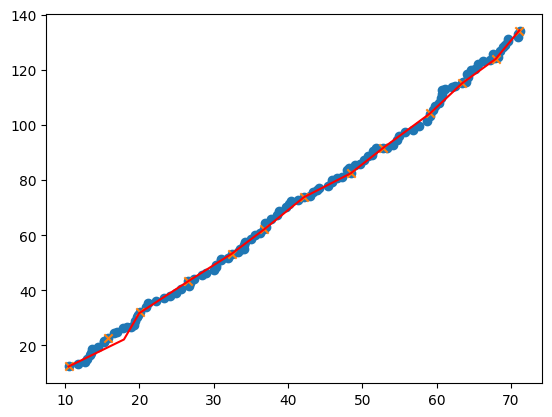

In [9]:

Ny = sim_records["radar1"]["t"].shape[0]

x_meas = np.zeros((Ny, 3))

for i in range(Ny):
    x_meas[i] = hinv([sim_records["radar1"]["target_az"][i],
                      sim_records["radar1"]["target_el"][i],
                      sim_records["radar1"]["target_rng"][i]])[:3]

plt.scatter(sim_records["lti_object2"]["x"], sim_records["lti_object2"]["y"])
plt.scatter(sim_records["lti_object1"]["x"][0] + x_meas[:, 0],
            sim_records["lti_object1"]["y"][0] + x_meas[:, 1], marker="x")
plt.plot(sim_records["lti_object1"]["x"][0] + kf_record["x_hat"][:, 0],
            sim_records["lti_object1"]["y"][0] + kf_record["x_hat"][:, 1], color="red")

In [9]:
def compute_error(gt: GroundTruth, tr: Track):
    err = np.zeros((len(tr.state_hist), 6))
    uncert = np.zeros_like(err)
    ts = np.zeros(len(tr.state_hist))
    for i, (x_hat, P, t) in enumerate(tr.state_hist):
        found = False
        for h in gt.history:
            if np.isclose(h[0], t):
                err[i] = h[1] - x_hat
                found = True
                break

        if not found:
            print(f"did not find ground truth from time {t}")

        for j in range(6):
            uncert[i, j] = 2 * np.sqrt(P[j, j])

        ts[i] = t

    return err, uncert, ts


def plot_errors(err, uncert, ts, title=""):
    fig, axs = plt.subplots(6, sharex=True)
    fig.set_size_inches((8, 10))
    fig.suptitle(title)

    states = ["x", "y", "z", "xdot", "ydot", "zdot"]
    units = ["m", "m", "m", "m^2", "m^2", "m^2"]

    for i in range(6):
        axs[i].set_title(states[i])
        axs[i].set_ylabel(units[i])
        axs[i].plot(ts, err[:, i], label="x_hat err")
        axs[i].plot(ts[1:], -uncert[1:, i], color="green", linestyle="dashed", label="2 sigma uncert")
        axs[i].plot(ts[1:], uncert[1:, i], color="green", linestyle="dashed")

    axs[0].legend()
    axs[5].set_xlabel("time")

    fig.tight_layout()

    return fig

In [16]:
def ekf_factory(meas: Measurement) -> Track:
    x0_hat = hinv(meas.y)
    P0_hat = np.eye(6) * 1e9

    return ExtendedKalman(x0_hat, P0_hat, f, get_F, h, get_H, Q, R * 1.15)

tracker_params = TrackerParam(associator_type="truth",
                              initeator_type="truth",
                              deletor_type="truth",
                              pda_cr=0,
                              filter_factory=ekf_factory)

tracker = Tracker(tracker_params)

for frame in sim.meas_queue:
    tracker.process_frame(frame)

track = tracker.tracks[0]
gt = sim._sim_objects[-1].ground_truth

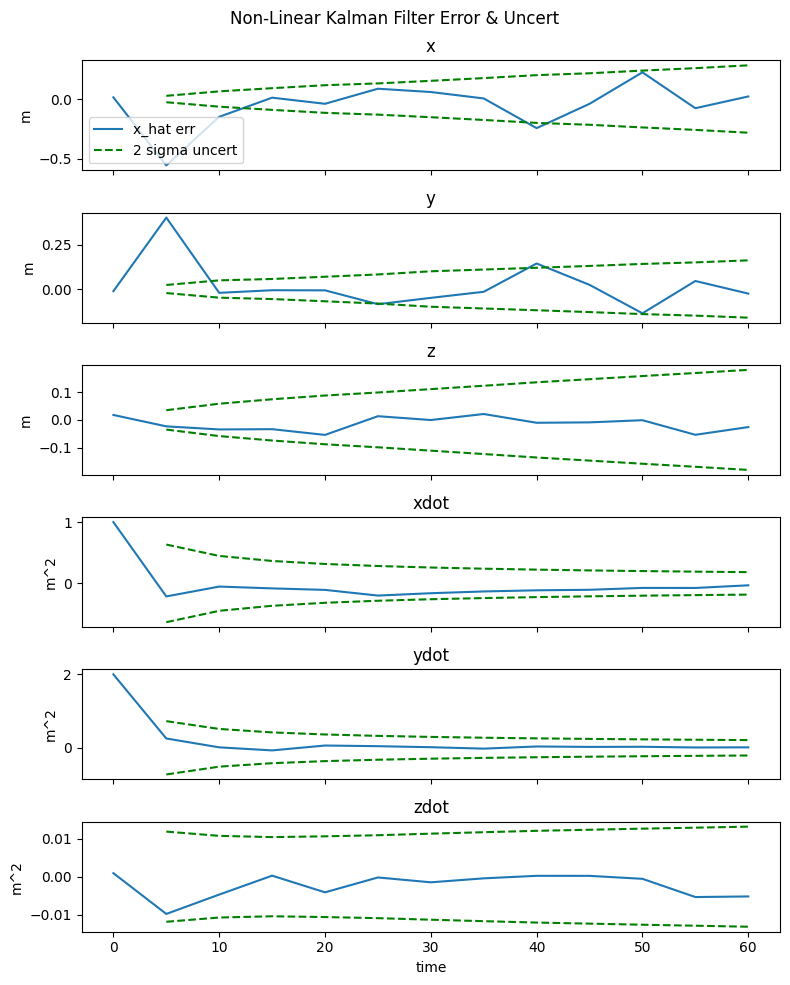

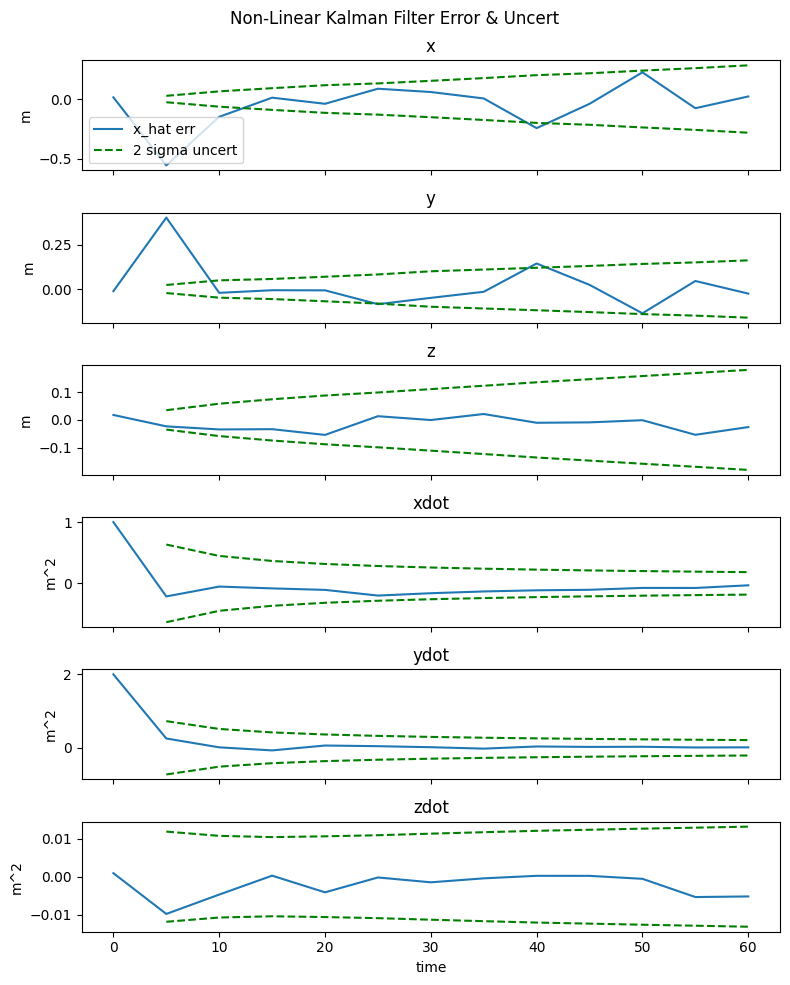

In [17]:
err, uncert, t = compute_error(gt, track)
plot_errors(err, uncert, t, title="Non-Linear Kalman Filter Error & Uncert")